# MLP on MNIST
**This notebook: [see on github](https://github.com/drinkingkazu/2019-06-17-NeuralNets/blob/master/MNIST%20MLP.ipynb) or [run it on google colab](https://colab.research.google.com/github/drinkingkazu/2019-06-17-NeuralNets/blob/master/MNIST%20MLP.ipynb)**.

In this notebook, we will implement multi-layer perceptron to classify hand-written digits from 0 to 9. The dataset is public and called [_MNIST_](http://yann.lecun.com/exdb/mnist/). 

* [MNIST dataset](#dataset)
* [Define the network, Multi Layer Perceptron (MLP)](#network)
* [Train the network](#train)
* [Save & Retrieve the trained network](#save)
* [Inference analysis](#inference)

In [1]:
from __future__ import print_function
import torch
import numpy as np

For reproducibility, we set the random number seed first.

In [2]:
SEED=123
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

We will use [`kworkshop.utils`](https://github.com/drinkingkazu/kworkshop/blob/master/utils) package. In case it's not available here, curl it.

In [3]:
! [ -d kworkshop ] || git clone -b 2019-06-17-NeuralNets https://github.com/drinkingkazu/kworkshop

<a href="dataset"></a>
# MNIST dataset
MNIST is widely used for an introductory machine learning (ML) courses/lectures. Most, if not all, ML libraries provide an easy way (API) to access MNIST and many publicly available dataset. This is true in `pytorch` as well. MNIST dataset in `Dataset` instance is available from `torchvision`. 

## Creating dataset (will download)

In [4]:
from torchvision import datasets, transforms
# Data file download directory
LOCAL_DATA_DIR = './data'
# Use prepared data handler from pytorch (torchvision)
dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

The dataset is a collection of hand-written digit images (28x28 pixels) and a label (integer 0 to 9) per image. For each data, index 0 is the image, and 1 is an integer label. `dataset[0][0]` is the 0th image data (numpy array) in the dataset, and `dataset[0][1]` is the corresponding label. Let's visualize data with a label.

60000 images prepared!
Length of each "data": 2
Shape  of image: torch.Size([1, 28, 28])
Label: 5


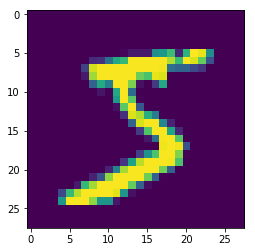

In [5]:
print(len(dataset),'images prepared!')
print('Length of each "data":',len(dataset[0]))
print('Shape  of image:',dataset[0][0].shape)
# Draw first data image
import matplotlib.pyplot as plt
%matplotlib inline
# Print label
print('Label:',dataset[0][1])
# Draw data
plt.imshow(dataset[0][0].view(dataset[0][0].shape[1:]))
plt.show()

## Creating DataLoader
For stochastic gradient training, we need a capability to randomly select a subset of dataset many times. This part is important: we want to maximize the time spent for training, not reading data and making it available for training.  

Pytorch (and almost all ML libraries) provides a utility to do this so that you don't have to reinvent. This is called `DataLoader`, and here is how you can create.

In [6]:
train_loader = torch.utils.data.DataLoader(dataset,batch_size=20,shuffle=True,num_workers=1,pin_memory=True)

The first argument is you dataset, and it can be anything but requires two attributes: [`__len__`](https://docs.python.org/3/reference/datamodel.html#object.__len__) and [`__getitem__`](https://docs.python.org/3/reference/datamodel.html#object.__getitem__). In case you wonder, these attributes allow you to call `len(dataset)` and access dataset elements  by `dataset[X]` where `X` is an index integer.

The other constructor arguments used above are:
* `batch_size` ... the same of the subset data to be provided at once
* `shuffle` ... whether or not to randomize the choice of subset dataset (False will provide dataset
* `num_workers` ... number of parallel data-reader processes to be run (for making data read faster using `multiprocessing` module)
* `pin_memory` ... speed up data transfer to GPU by avoiding a necessiry to copy data from pageable memory to page-locked (pinned) memory. Read [here](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/) for more details. If you are not sure about the details, set to `True` when using GPU. 

<a href="network"></a>
# Define a network
In `pytorch`, a network is defined as a `torch.Module` inherited class. In this class, we define the network architecture as well as a _forward_ function to process input image data and perform a digit classification task.

Our network will be MLP with 2 hidden layers, 128 neurons in each layer. 

In [7]:
class MLP(torch.nn.Module):
    def __init__(self):
        
        super(MLP, self).__init__()        
        # MLP w/ 2 hidden layers, 128 neurons each
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(28*28, 128), torch.nn.ReLU(),
            torch.nn.Linear(128,128), torch.nn.ReLU(),
            torch.nn.Linear(128,10)
        )

    def forward(self, x):
        # Make 2d image into 1D array
        x_1d = x.view(-1, np.prod(x.size()[1:]))
        return self._classifier(x_1d)

<a href="train"></a>
# Train the network
Next, we will write a train loop function in which a subset (i.e. "batch") of data is processed, loss is computed, and network weights are updated via back-propagation. Each attempt in the loop is called an **_iteration_**. 

## _blob_
For convenience, define a _BLOB_ class to keep objects together. To a BLOB instance, we attach MLP, our loss function (`nn.CrossEntropyLoss`), and Adam optimizer algorithm. For analysis purpose, we also include `nn.Softmax`. Finally, we attach data and label place holders.

In [8]:
class BLOB:
    pass
blob=BLOB()
blob.net       = MLP().cuda() # construct Lenet, use GPU
blob.criterion = torch.nn.CrossEntropyLoss() # use softmax loss to define an error
blob.optimizer = torch.optim.Adam(blob.net.parameters()) # use Adam optimizer algorithm
blob.softmax   = torch.nn.Softmax(dim=1) # not for training, but softmax score for each class
blob.iteration = 0    # integer count for the number of train steps
blob.data      = None # data for training/analysis
blob.label     = None # label for training/analysis

## "forward" and "backward"
We define 2 functions to be called in the training loop: _forward_, which computes the network output, and _backward_, which calculates the loss and propagate the gradients for weight update. Later, when we use the trained network for data analysis, we can re-use the forward function. The name "backward" is because the computation starts from the error (=end result of forward) and proceed toward the input (=start of forward).

In [9]:
def forward(blob,train=True):
    """
       Args: blob should have attributes, net, criterion, softmax, data, label
       
       Returns: a dictionary of predicted labels, softmax, loss, and accuracy
    """
    with torch.set_grad_enabled(train):
        # Prediction
        data = blob.data.cuda()
        prediction = blob.net(data)
        # Training
        loss,acc=-1,-1
        if blob.label is not None:
            label = blob.label.cuda()
            loss = blob.criterion(prediction,label)
        blob.loss = loss
        
        softmax    = blob.softmax(prediction).cpu().detach().numpy()
        prediction = torch.argmax(prediction,dim=-1)
        accuracy   = (prediction == label).sum().item() / float(prediction.nelement())        
        prediction = prediction.cpu().detach().numpy()
        
        return {'prediction' : prediction,
                'softmax'    : softmax,
                'loss'       : loss.cpu().detach().item(),
                'accuracy'   : accuracy}

def backward(blob):
    blob.optimizer.zero_grad()  # Reset gradients accumulation
    blob.loss.backward()
    blob.optimizer.step()


## Training loop

Now we are ready for training! Let's define train_loop function which calls both `forward` and `backward`.

In [10]:
def train_loop(blob,train_loader,num_iteration):
    # Set the network to training mode
    blob.net.train()
    # Let's record the loss at each iteration and return
    train_loss=[]
    # Loop over data samples and into the network forward function
    for i,data in enumerate(train_loader):
        if blob.iteration >= num_iteration:
            break
        blob.iteration += 1
        # data and label
        blob.data, blob.label = data
        # call forward
        res = forward(blob,True)
        # Recird loss
        train_loss.append(res['loss'])
        # once in a while, report
        if blob.iteration == 0 or (blob.iteration+1)%100 == 0:
            print('Iteration',blob.iteration,'... Loss',res['loss'],'... Accuracy',res['accuracy'])
        backward(blob)
    return np.array(train_loss)

Now train:

In [11]:
loss = train_loop(blob,train_loader,num_iteration=2000)

Iteration 99 ... Loss 1.089469313621521 ... Accuracy 0.55
Iteration 199 ... Loss 0.5556436777114868 ... Accuracy 0.75
Iteration 299 ... Loss 0.4601459503173828 ... Accuracy 0.85
Iteration 399 ... Loss 0.2137332409620285 ... Accuracy 0.95
Iteration 499 ... Loss 0.6610696911811829 ... Accuracy 0.75
Iteration 599 ... Loss 0.1977153718471527 ... Accuracy 0.9
Iteration 699 ... Loss 0.30119359493255615 ... Accuracy 0.85
Iteration 799 ... Loss 0.09584233909845352 ... Accuracy 1.0
Iteration 899 ... Loss 0.16781406104564667 ... Accuracy 0.95
Iteration 999 ... Loss 0.370830237865448 ... Accuracy 0.85
Iteration 1099 ... Loss 0.7638367414474487 ... Accuracy 0.8
Iteration 1199 ... Loss 0.25620999932289124 ... Accuracy 0.95
Iteration 1299 ... Loss 0.05520975589752197 ... Accuracy 1.0
Iteration 1399 ... Loss 0.056445516645908356 ... Accuracy 1.0
Iteration 1499 ... Loss 0.4079981744289398 ... Accuracy 0.85
Iteration 1599 ... Loss 0.20770592987537384 ... Accuracy 0.95
Iteration 1699 ... Loss 0.31837853

It's very important to validate basic facts. At the very beginning, the network's guess should be random (accuracy ~0.1). The accuracy should be indicated in the step of 0.05 since our batch size is 20. This training shows anything strange but successful.

Let's try plotting the loss value. 

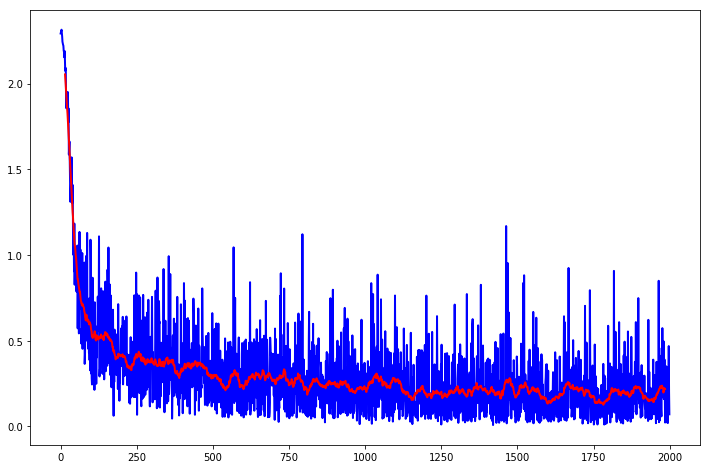

In [12]:
fig,ax=plt.subplots(figsize=(12,8),facecolor='w')
plt.plot(range(len(loss)),loss,marker="",linewidth=2,color='blue')
from kworkshop.utils import moving_average 
plt.plot(moving_average(range(len(loss)),30),moving_average(loss,30),marker="",linewidth=2,color='red')
plt.show()

<a href="save"></a>
# Saving & Restoring the states
After spending some time and money for computing the network weights, it's a good idea to learn how to save the state so that you can come back and restart the training from where you were, or use it for analysis. We define two functions for saving and restoring the weights.

In [13]:
def save_state(blob, prefix='./snapshot'):
    # Output file name
    filename = '%s-%d.ckpt' % (prefix, blob.iteration)
    # Save parameters
    # 0+1) iteration counter + optimizer state => in case we want to "continue training" later
    # 2) network weight
    torch.save({
        'global_step': blob.iteration,
        'optimizer': blob.optimizer.state_dict(),
        'state_dict': blob.net.state_dict()
        }, filename)
    return filename

def restore_state(blob, weight_file):
    # Open a file in read-binary mode
    with open(weight_file, 'rb') as f:
        # torch interprets the file, then we can access using string keys
        checkpoint = torch.load(f)
        # load network weights
        blob.net.load_state_dict(checkpoint['state_dict'], strict=False)
        # if optimizer is provided, load the state of the optimizer
        if blob.optimizer is not None:
            blob.optimizer.load_state_dict(checkpoint['optimizer'])
        # load iteration count
        blob.iteration = checkpoint['global_step']

Let's save the current state:

In [14]:
weight_file = save_state(blob)

Next, for a demonstration, we'll reset the network by creating a new instance. Let's also make sure that the network performance should go back to a random guess.

In [15]:
# Recreate the network (i.e. initialize)
blob.net=MLP().cuda()
# Get one batch of data to test
blob.data, blob.label = next(iter(train_loader))
# Run forward function
res = forward(blob,True)
# Report
print('Accuracy:',res['accuracy'])


Accuracy: 0.0


As expected, the accuracy is close to a random guess (0.1). Next, let's load the saved state and check the accuracy on the same data.

In [16]:
# Restore the state
restore_state(blob,weight_file)
# Run the forward function
res = forward(blob,True)
# Report
print('Accuracy',res['accuracy'])

Accuracy 1.0


We successfully loaded the saved weights.
<a href="inference"></a>
# Evaluation
When we use a supervised training technique on a train dataset, we often worry about _over training_, which means some features learned by the network is specific to the train set and not useful in general. In order to make sure what was learned during the training stays relevant, we should test the network's performance on a statistically independent dataset, called _test sample_ (or loosely _validation sample_).

We define a function that runs inference and returns an accuracy (per batch), label (per image), and prediction (per image)

In [17]:
def inference_loop(blob,train=False):
    # load the test dataset
    dataset = datasets.MNIST(LOCAL_DATA_DIR, train=train, download=True,
                             transform=transforms.Compose([transforms.ToTensor()]))
    # create DataLoader
    test_loader = torch.utils.data.DataLoader(dataset,batch_size=40,shuffle=False,num_workers=2,pin_memory=True)
    # set the network to test (non-train) mode
    blob.net.eval()
    # create the result holder
    accuracy, label, prediction, softmax = [], [], [], []
    confusion_matrix = np.zeros([10,10],dtype=np.int32)
    for i,data in enumerate(test_loader):
        blob.data, blob.label = data
        res = forward(blob,True)
        accuracy.append(res['accuracy'])
        prediction.append(res['prediction'])
        label.append(blob.label)
        softmax.append(res['softmax'])
    # organize the return values
    accuracy   = np.hstack(accuracy)
    prediction = np.hstack(prediction)
    label      = np.hstack(label)
    softmax    = np.vstack(softmax)
    return accuracy, label, prediction, softmax

Let's run the inference for both train and test datasets.

Train set accuracy mean 0.9479333333333333 std 0.03755967104340623


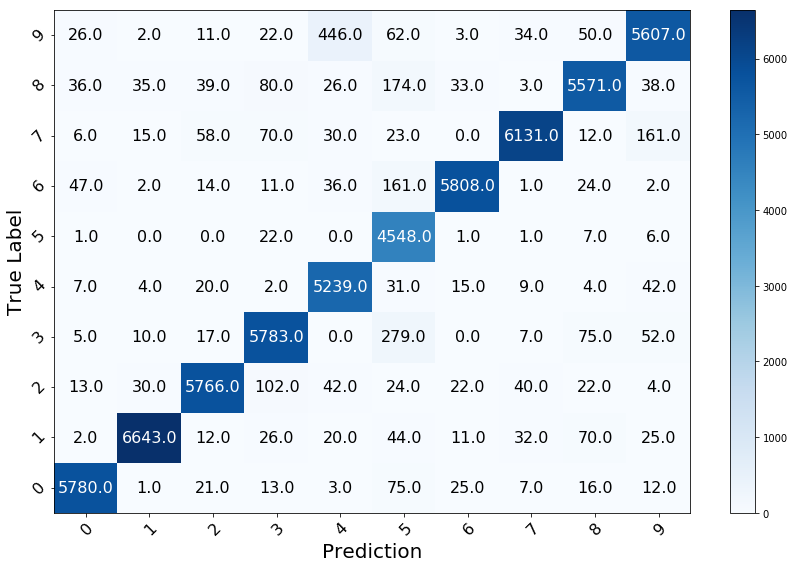

Test set accuracy mean 0.9464 std 0.04366966910797469


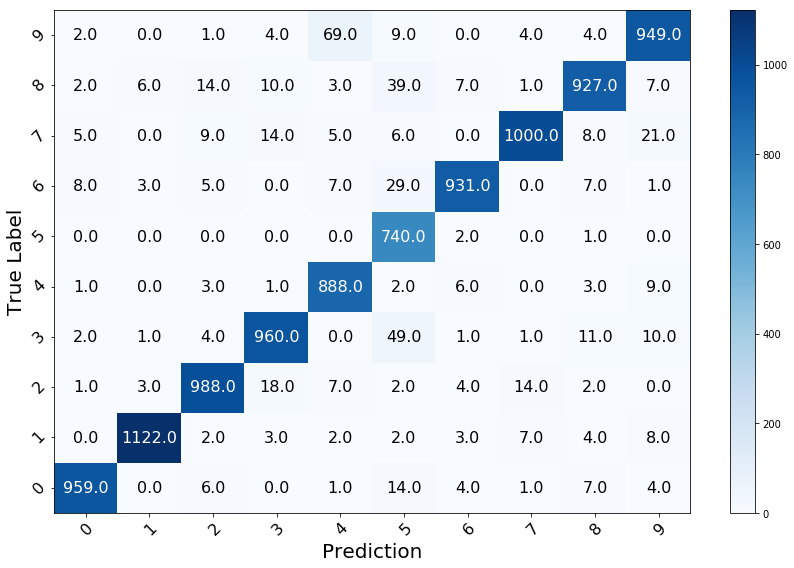

In [18]:
# For plotting a confusion matrix
from kworkshop.utils import plot_confusion_matrix

# For the Train set
accuracy, label, prediction, softmax = inference_loop(blob,True)
print("Train set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])

# For the Test set
accuracy, label, prediction, softmax = inference_loop(blob,False)
print("Test set accuracy mean",accuracy.mean(),"std",accuracy.std())
plot_confusion_matrix(label,prediction,[str(d) for d in range(10)])


The results look quite similar between the train and test datasets (note the overall normalization is different). This suggests there was no overtraining in this exercise :)

In [19]:
def plot_softmax(label,softmax):
    num_class   = len(softmax[0])
    unit_angle  = 2*np.pi/num_class
    xs = np.array([ np.sin(unit_angle*i) for i in range(num_class+1)])
    ys = np.array([ np.cos(unit_angle*i) for i in range(num_class+1)])
    fig,axis=plt.subplots(figsize=(10,10),facecolor='w')
    plt.plot(xs,ys)#,linestyle='',marker='o',markersize=20)
    for d in range(num_class):
        plt.text(xs[d]*1.1-0.04,ys[d]*1.1-0.04,str(d),fontsize=24)
    plt.xlim(-1.3,1.3)
    plt.ylim(-1.3,1.3)
    
    xs=xs[0:10]
    ys=ys[0:10]
    for d in range(num_class):
        idx=np.where(label==d)
        scores=softmax[idx]
        xpos=[np.sum(xs * s) for s in scores]
        ypos=[np.sum(ys * s) for s in scores]
        plt.plot(xpos,ypos,linestyle='',marker='o',markersize=10,alpha=0.5)
    ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,labelleft=False,labelbottom=False)
    plt.show()

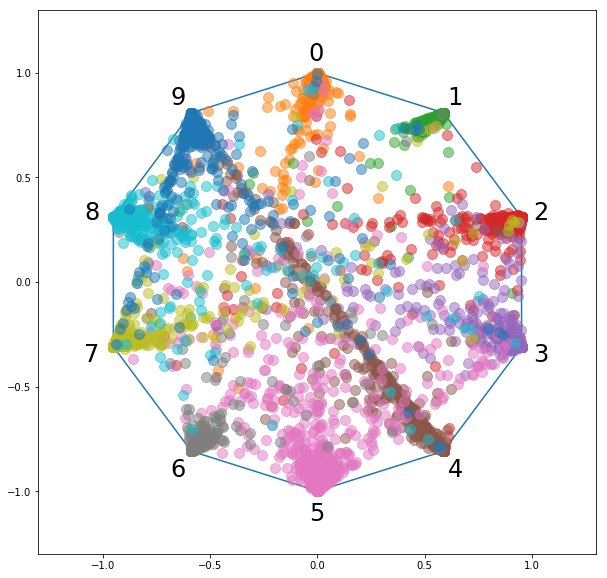

In [20]:
plot_softmax(label,softmax)